In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models

from tempfile import TemporaryDirectory

In [4]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f'Device using: {device}')

Device using: mps


In [5]:
# test_device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu"
# test_device

In [6]:
# load dataset

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_transforms

{'train': Compose(
     RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
     RandomHorizontalFlip(p=0.5)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 'val': Compose(
     Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
     CenterCrop(size=(224, 224))
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 )}

In [7]:
# dir(datasets)
# datasets.ImageFolder()
# DataLoader()

In [8]:
folder_path = "hymenoptera_data"
folder_data = ["train", "val"]

# folder_path+"/"+x _> other way to join

# create a image folder
image_datasets = {x: datasets.ImageFolder(os.path.join(folder_path, x), data_transforms[x]) for x in folder_data}

# create a dataloader
dataloaders = {x: DataLoader(image_datasets[x], batch_size = 4, shuffle=True, num_workers=4) for x in folder_data}

dataset_sizes = {x: len(image_datasets[x]) for x in folder_data}
print(f'Dataset Sizes: {dataset_sizes}')

# get labels
class_names = image_datasets["train"].classes
print(f'Class Names: {class_names}')

Dataset Sizes: {'train': 244, 'val': 153}
Class Names: ['ants', 'bees']


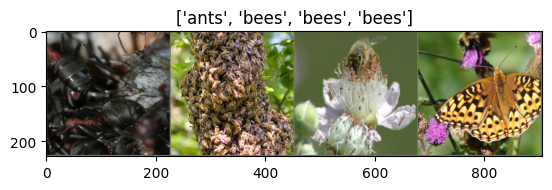

In [9]:
def imshow(image, title=None):
    image = image.numpy().transpose([1,2,0])
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.0001)

inputs, classes = next(iter(dataloaders["train"]))

# inputs shape is [4, 3, 224, 224] -> 4=batch size, 3=rgb image 224,224=image shape
inputs.shape, classes

# make grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, [class_names[x] for x in classes])

In [18]:
# model train function
def train(model, lossfn, optimizer, scheduler, epochs):
    with TemporaryDirectory() as temp_dir:
        best_model_params_path = os.path.join(temp_dir, "best_model_params.pt")
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        for epoch in range(epochs):
            running_loss = 0.0
            running_corrects = 0
            for phase in folder_data:
                if phase == "train":
                    model.train()
                else:
                    model.eval()
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, pred = torch.max(outputs, 1)
                        loss = lossfn(pred, labels)
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                            
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(pred == labels.data)
                if phase == "train":
                    scheduler.step()
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict, best_model_params_path)
        print("ok")
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [19]:
models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
model_ft = model_ft.to(device)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model_ft.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [21]:
epochs = 2
model_ft = train(model_ft, loss, optimizer, scheduler, epochs)

RuntimeError: Tensor for argument weight is on cpu but expected on mps

In [ ]:
# import numpy as np

# def transposed_convolution(input_matrix, kernel, stride=1):
#     input_size = input_matrix.shape[0]
#     kernel_size = kernel.shape[0]
    
#     # Compute output size
#     output_size = (input_size - 1) * stride + kernel_size
#     output_matrix = np.zeros((output_size, output_size))
    
#     # Perform transposed convolution
#     for i in range(input_size):
#         for j in range(input_size):
#             output_matrix[i:i+kernel_size, j:j+kernel_size] += input_matrix[i, j] * kernel
    
#     return output_matrix

# # Given input matrix
# input_matrix = np.array([
#     [2, 0, -1, -1],
#     [0, 1, 0, 2],
#     [-2, 0, 1, 1],
#     [1, 1, 0, -1]
# ])

# # Given filter (kernel)
# kernel = np.array([
#     [1, -1, 1],
#     [0, 1, 0],
#     [1, -1, 1]
# ])

# # Compute transposed convolution
# output_matrix = transposed_convolution(input_matrix, kernel)

# # Print result
# print("Transposed Convolution Output:")
# print(output_matrix)